In [1]:
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE

from gensim.models import Word2Vec
from bs4 import BeautifulSoup

import re
import psycopg2
import json

import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px

In [2]:
from ui_db import DBConnection
DB = DBConnection()
DB.connect()
df = pd.DataFrame(json.loads(DB.getArticles()))

In [3]:
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    clean_text = soup.get_text()

    # Remove additional unwanted characters or spaces
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()

    return clean_text


# Preprocessing function
def preprocess_text(text):
    text = remove_html_tags(text)
    stop_words = set(stopwords.words('dutch'))
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalpha() and token not in stop_words]
    return " ".join(tokens)


In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pimvandenbosch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pimvandenbosch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pimvandenbosch/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# Preprocess the news article titles and summaries
df['preprocessed'] = df['Title'].apply(preprocess_text) + " " + df['Summary'].apply(lambda x: preprocess_text(str(x)))

/var/folders/0v/w8c69m6s5f1bg9sd70tmvz4w0000gn/T/ipykernel_12469/460904931.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


In [6]:
# Convert the preprocessed text into numerical vectors using TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['preprocessed'])

# Optional: Apply dimensionality reduction using SVD
svd = TruncatedSVD(n_components=100)
X_reduced = svd.fit_transform(X_tfidf)

In [7]:
"""
When clustering news articles based on their titles and summaries, the choice of eps and min_samples should take into account the unique characteristics of textual data.

eps: 

Since you're using TF-IDF and cosine similarity to measure the distance between text documents, 
the distances will range between 0 (identical documents) and 1 (completely dissimilar documents). 
In this case, you can start with a small eps value, like 0.3 or 0.5, and experiment with different values based on the k-distance graph method. 
This will help you determine a reasonable eps value that allows the algorithm to identify clusters without merging unrelated articles.

min_samples: 

Textual data tends to be sparse, and the number of relevant features (words or phrases) may vary across documents. 
A smaller value of min_samples might be more appropriate for text data, as it may allow the algorithm to capture smaller clusters. 
You can start with a small value for min_samples, such as 2 or 3, and incrementally increase it to evaluate the impact on the clustering results.
"""

"""
def get_k_distance_graph(X, k):
    # Compute the k-th nearest neighbor distances
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    
    # Get the k-th nearest neighbor distances for each point
    k_distances = distances[:, -1]

    # Sort the distances in ascending order
    sorted_distances = np.sort(k_distances)
    
    return sorted_distances

def plot_k_distance_graph(sorted_distances, k):
    # Plot the k-distance graph
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(sorted_distances)), sorted_distances)
    plt.xlabel('Points sorted by distance to the k-th nearest neighbor')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.title(f'{k}-distance graph')
    plt.show()

# Choose an appropriate value for k (e.g., equal to min_samples)
k = 2

# Compute the k-distance graph
sorted_distances = get_k_distance_graph(X_reduced, k)

# Plot the k-distance graph
plot_k_distance_graph(sorted_distances, k)
"""

#Conclusion: eps=0.55 seems to be ideal
#Conclusion: min_samples=2 because the smallest cluster is logically 2 articles covering the same topic.

"\ndef get_k_distance_graph(X, k):\n    # Compute the k-th nearest neighbor distances\n    neigh = NearestNeighbors(n_neighbors=k)\n    neigh.fit(X)\n    distances, _ = neigh.kneighbors(X)\n    \n    # Get the k-th nearest neighbor distances for each point\n    k_distances = distances[:, -1]\n\n    # Sort the distances in ascending order\n    sorted_distances = np.sort(k_distances)\n    \n    return sorted_distances\n\ndef plot_k_distance_graph(sorted_distances, k):\n    # Plot the k-distance graph\n    plt.figure(figsize=(12, 6))\n    plt.plot(range(len(sorted_distances)), sorted_distances)\n    plt.xlabel('Points sorted by distance to the k-th nearest neighbor')\n    plt.ylabel(f'{k}-th nearest neighbor distance')\n    plt.title(f'{k}-distance graph')\n    plt.show()\n\n# Choose an appropriate value for k (e.g., equal to min_samples)\nk = 2\n\n# Compute the k-distance graph\nsorted_distances = get_k_distance_graph(X_reduced, k)\n\n# Plot the k-distance graph\nplot_k_distance_graph(so

In [15]:
# Apply DBSCAN algorithm
dbscan = DBSCAN(eps=0.55, min_samples=2, metric='cosine')
clusters = dbscan.fit_predict(X_reduced)

In [16]:
# Assign the cluster labels to the original DataFrame
df['cluster'] = clusters

In [17]:
"""
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', None)     # Display all rows
pd.set_option('display.max_colwidth', None) # Display full column content without truncation

# Print the clustered news articles
for cluster_id in np.unique(clusters):
    if cluster_id == -1:
        continue
    print(f"Cluster {cluster_id}:")
    #print(df[df['cluster'] == cluster_id][['Title', 'Summary']])
    print(df[df['cluster'] == cluster_id]['preprocessed'])
    
    print("\n")
    
"""

'\npd.set_option(\'display.max_columns\', None)  # Display all columns\npd.set_option(\'display.max_rows\', None)     # Display all rows\npd.set_option(\'display.max_colwidth\', None) # Display full column content without truncation\n\n# Print the clustered news articles\nfor cluster_id in np.unique(clusters):\n    if cluster_id == -1:\n        continue\n    print(f"Cluster {cluster_id}:")\n    #print(df[df[\'cluster\'] == cluster_id][[\'Title\', \'Summary\']])\n    print(df[df[\'cluster\'] == cluster_id][\'preprocessed\'])\n    \n    print("\n")\n    \n'

In [18]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_reduced)

In [19]:
"""
plt.figure(figsize=(12, 8))
for cluster_id in np.unique(clusters):
    if cluster_id == -1:
        color = 'gray'
    else:
        color = plt.cm.rainbow(cluster_id / len(np.unique(clusters)))
    plt.scatter(X_tsne[clusters == cluster_id, 0], X_tsne[clusters == cluster_id, 1], c=[color], label=f"Cluster {cluster_id}")
plt.legend()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE visualization of clusters')
plt.show()
"""

'\nplt.figure(figsize=(12, 8))\nfor cluster_id in np.unique(clusters):\n    if cluster_id == -1:\n        color = \'gray\'\n    else:\n        color = plt.cm.rainbow(cluster_id / len(np.unique(clusters)))\n    plt.scatter(X_tsne[clusters == cluster_id, 0], X_tsne[clusters == cluster_id, 1], c=[color], label=f"Cluster {cluster_id}")\nplt.legend()\nplt.xlabel(\'t-SNE 1\')\nplt.ylabel(\'t-SNE 2\')\nplt.title(\'t-SNE visualization of clusters\')\nplt.show()\n'

In [20]:
def split_text(text, max_length=50):
    words = text.split()
    lines = []
    current_line = []

    for word in words:
        if len(' '.join(current_line + [word])) <= max_length:
            current_line.append(word)
        else:
            lines.append(' '.join(current_line))
            current_line = [word]

    if current_line:
        lines.append(' '.join(current_line))

    return '<br>'.join(lines)

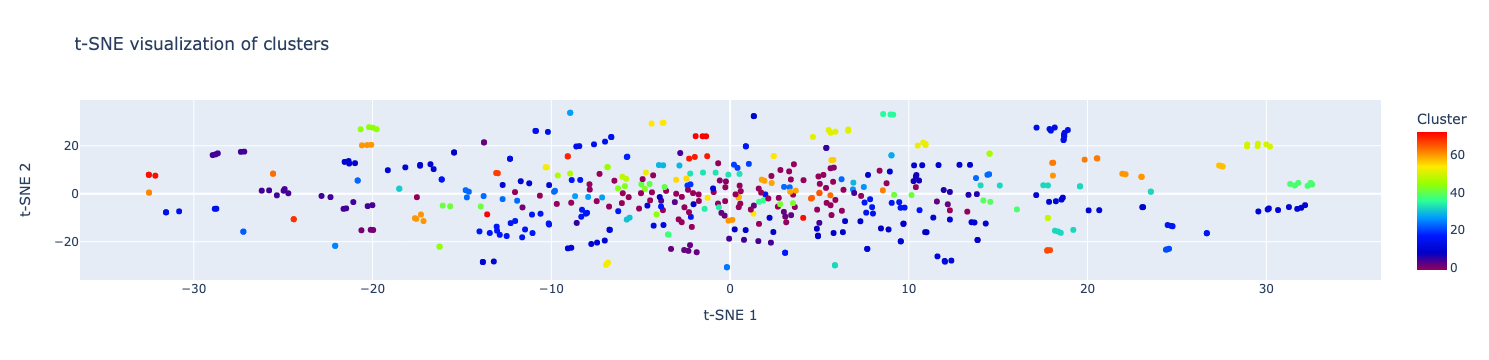

In [21]:
# Create a DataFrame with t-SNE data and cluster labels
"""
tsne_df = pd.DataFrame(X_tsne, columns=['t-SNE 1', 't-SNE 2'])
tsne_df['Cluster'] = clusters
tsne_df['Preprocessed'] = df['Title'].apply(split_text)+ ' ' +df['Summary'].apply(split_text)


# Create an interactive scatter plot
fig = px.scatter(tsne_df,
                 x='t-SNE 1',
                 y='t-SNE 2',
                 color='Cluster',
                 hover_data=['Preprocessed'],
                 color_continuous_scale=px.colors.sequential.Rainbow,
                 title='t-SNE visualization of clusters')

# Show the plot
fig.show()"""

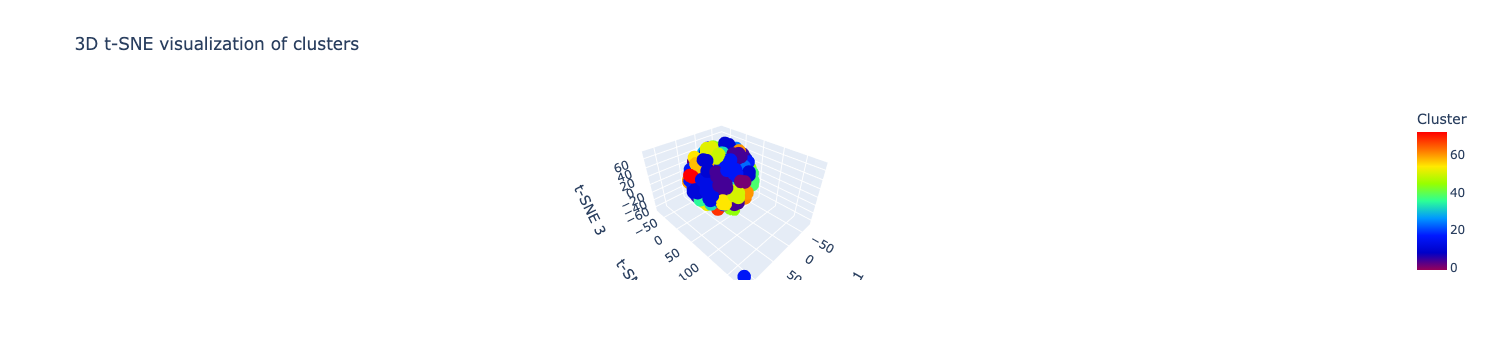

In [24]:
# Transform the reduced data into 3D t-SNE embeddings
tsne_3d = TSNE(n_components=3, random_state=42)
X_tsne_3d = tsne_3d.fit_transform(X_reduced)

# Create a DataFrame with 3D t-SNE data and cluster labels
tsne_df_3d = pd.DataFrame(X_tsne_3d, columns=['t-SNE 1', 't-SNE 2', 't-SNE 3'])
tsne_df_3d['Cluster'] = clusters
tsne_df_3d['Preprocessed'] = df['Title'].apply(split_text) + ' ' + df['Summary'].apply(split_text)

# Create an interactive 3D scatter plot
fig_3d = px.scatter_3d(tsne_df_3d,
                       x='t-SNE 1',
                       y='t-SNE 2',
                       z='t-SNE 3',
                       color='Cluster',
                       hover_data=['Preprocessed'],
                       color_continuous_scale=px.colors.sequential.Rainbow,
                       title='3D t-SNE visualization of clusters')

# Show the plot
fig_3d.show()